# Homework 3: Reproducibility in Climate Studies

* **Statistics 159/259, Spring 2022**
* **Due 03/23/2023, 23:59PM PT**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* This assignment is worth a maximum of **50 points**.
* Assignment type: **group homework assignment** (Check on Ed Discussion about group's assignments).

## 2. The West Coast Heat Wave

In 2016 [Dr. Chelle Gentemann](https://cgentemann.github.io) and collaborators published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. 
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

Subset all the data to just the West Coast region

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

This is how a rough version of one of the plots in the paper look like

In [3]:
from matplotlib import pyplot as plt

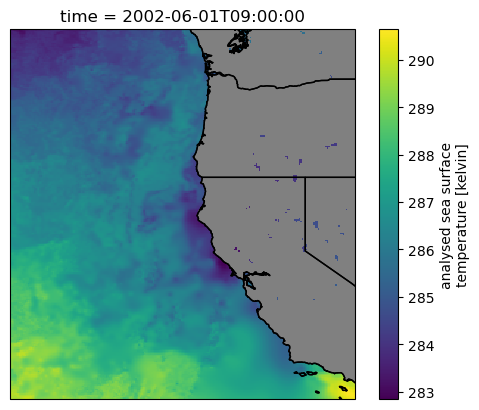

In [4]:
ds.analysed_sst[0, :, :].plot()

# Plot on a map
ax = plt.subplot(projection=crs)
ds.analysed_sst[0, :, :].plot(ax=ax, transform=crs)
ax.coastlines("10m", color="k")
ax.add_feature(cfeature.LAND, color="grey")
ax.add_feature(cfeature.STATES.with_scale("10m"))

### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [5]:
sst = ds['analysed_sst']
sst_celcius = sst-273.15

In [6]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

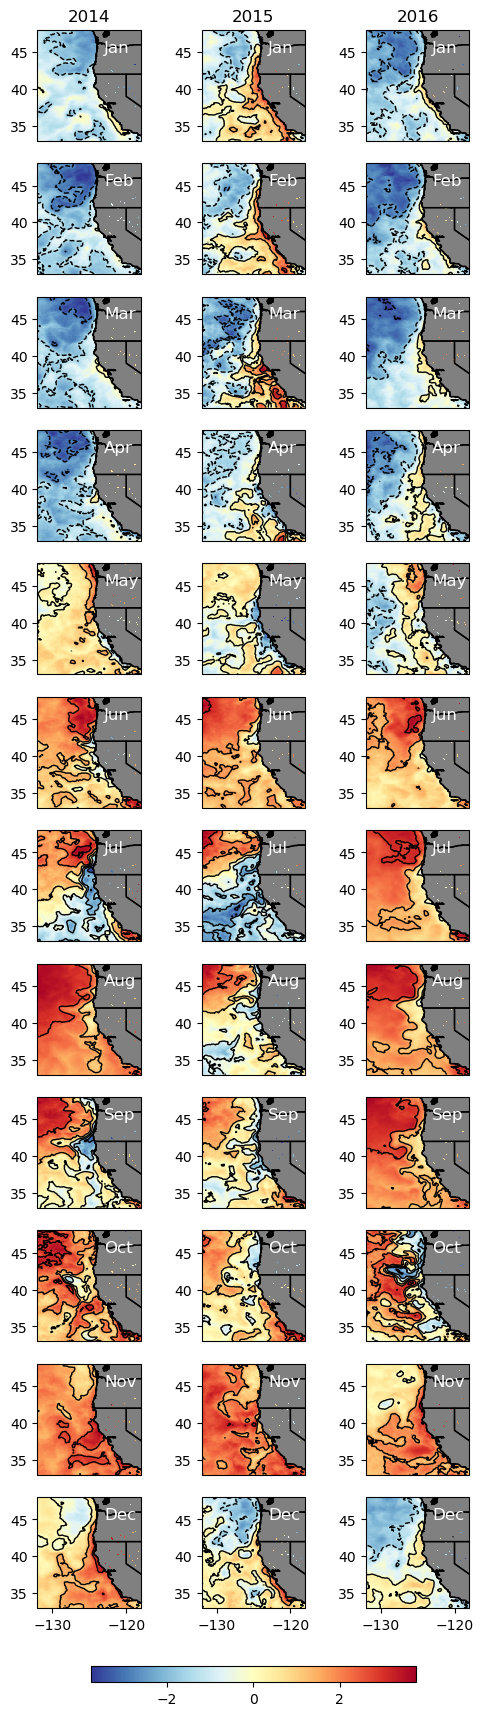

In [7]:
# create a 12x3 plot
fig, axs = plt.subplots(figsize=(6,25), nrows=12, ncols=3, subplot_kw=dict(projection=crs))

# loop through 2014-2016 and each year's 12 months to create a subplot for each month
for col in range(3):
    for row in range(12):
        
        # select data array with desired year-month and find its SD
        temp = sst_celcius.sel(time="{}-{}".format(col+2014,row+1)).mean(dim='time')
        # find the mean SST of all previous year-month
        prev = sst_celcius.sel(time=slice('2002-1',"{}-{}".format(col+2013,row+1))).mean(dim='time')
        # find the deviation between mean 2014-01 and mean all data before and include 2013-01
        dev = temp-prev
        
        cmap = dev.plot(ax=axs[row, col], transform=crs, add_colorbar=False,cmap='RdYlBu_r') # plot a color map
        dev.plot.contour(ax=axs[row, col], colors='black', linewidths=1, cmin=-3, cmax=3) # plot a contour for the map
        axs[row, col].set_yticks(range(35,46,5)) # add ticks for y axis
        axs[row, col].set_ylabel('') # remove y label
        
        if row==0:
            axs[row, col].set_title(str(col+2014)) # add title only if the plot is on the first row
        
        if row==11:
            axs[row, col].set_xticks(range(-130, -119, 10)) # add ticks for x axis only if the plot is on row #12
            axs[row, col].set_xlabel('') # remove x label
        
        axs[row, col].text(-123, 45, month[row], fontsize=12, color = 'white') # add month name
        axs[row, col].coastlines("10m", color="k")
        axs[row, col].add_feature(cfeature.LAND, color="grey")
        axs[row, col].add_feature(cfeature.STATES.with_scale("10m"))
        
# create a colorbar
plt.colorbar(cmap, ax=axs, location='bottom', shrink=0.7, pad=0.03)

# add ticks and labels to the color bar
#cbar.set_ticks(np.arange(0, 1.1, 0.5))
#cbar.set_ticklabels(['low', 'medium', 'high'])

plt.show()